In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import scipy.stats as stats

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

100%|██████████| 185k/185k [00:00<00:00, 42.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shashanknecrothapa/ames-housing-dataset/versions/1
['AmesHousing.csv']


## load data

In [3]:
df = pd.read_csv(path + '/AmesHousing.csv')
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

## EDA

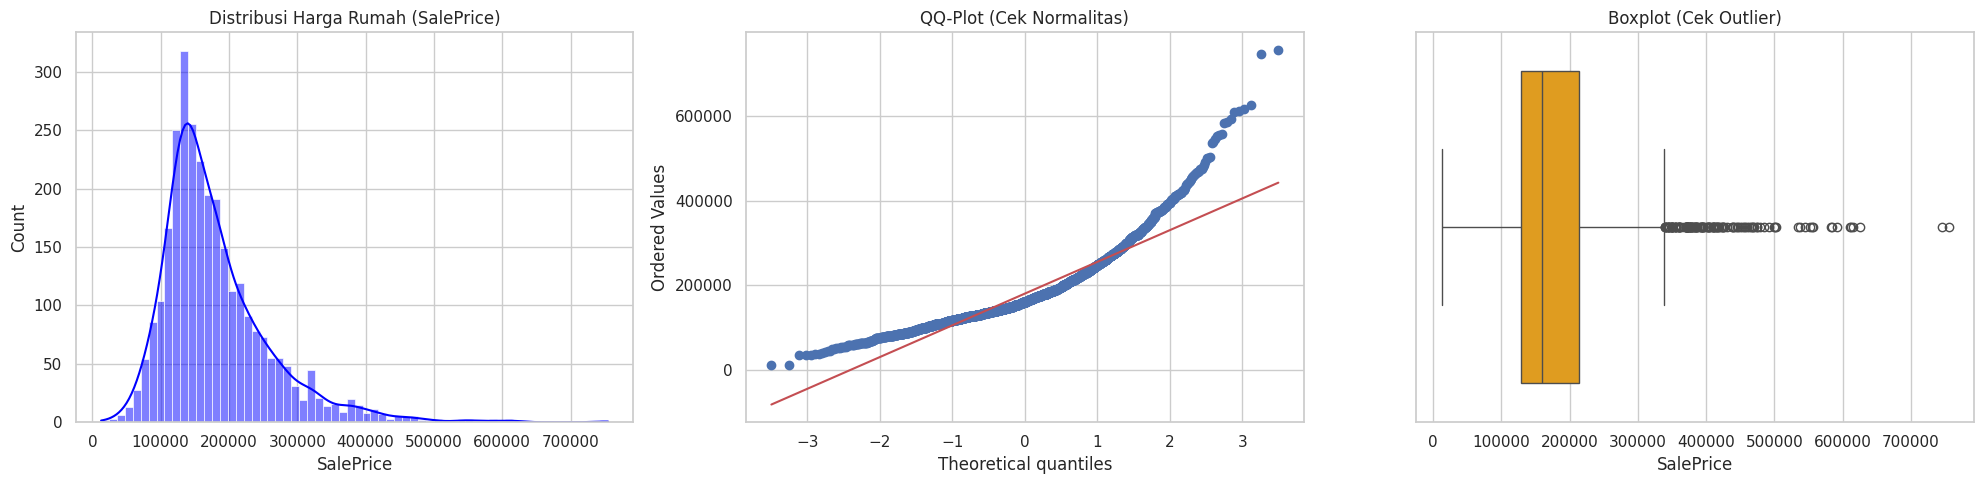

In [24]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(df['SalePrice'], kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribusi Harga Rumah (SalePrice)')

stats.probplot(df['SalePrice'], plot=ax[1])
ax[1].set_title('QQ-Plot (Cek Normalitas)')

sns.boxplot(x=df['SalePrice'], ax=ax[2], color='orange')
ax[2].set_title('Boxplot (Cek Outlier)')

plt.tight_layout()
plt.show()

In [25]:
print(f"Skewness: {df['SalePrice'].skew():.4f}")
print(f"Kurtosis: {df['SalePrice'].kurt():.4f}")

Skewness: 1.7435
Kurtosis: 5.1189


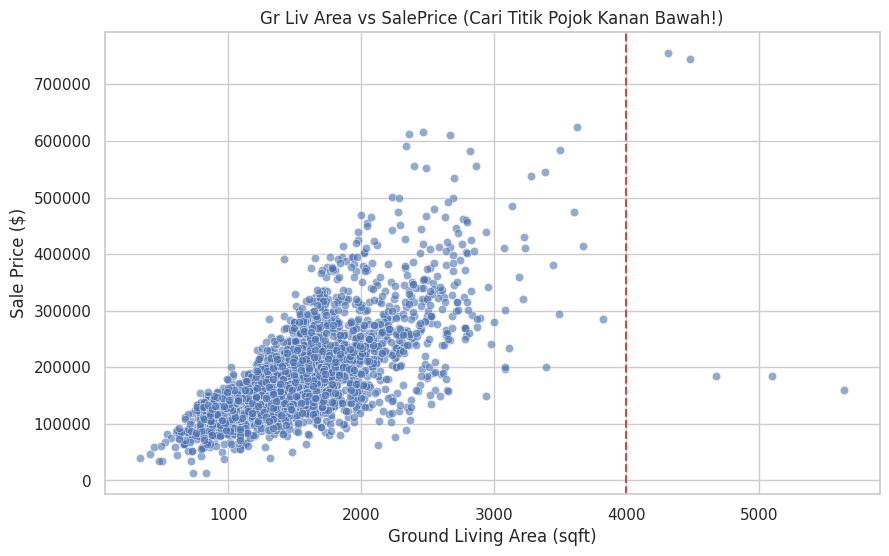

In [27]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Gr Liv Area'], y=df['SalePrice'], alpha=0.6)
plt.title('Gr Liv Area vs SalePrice (Cari Titik Pojok Kanan Bawah!)')
plt.xlabel('Ground Living Area (sqft)')
plt.ylabel('Sale Price ($)')
plt.axvline(x=4000, color='r', linestyle='--')
plt.show()

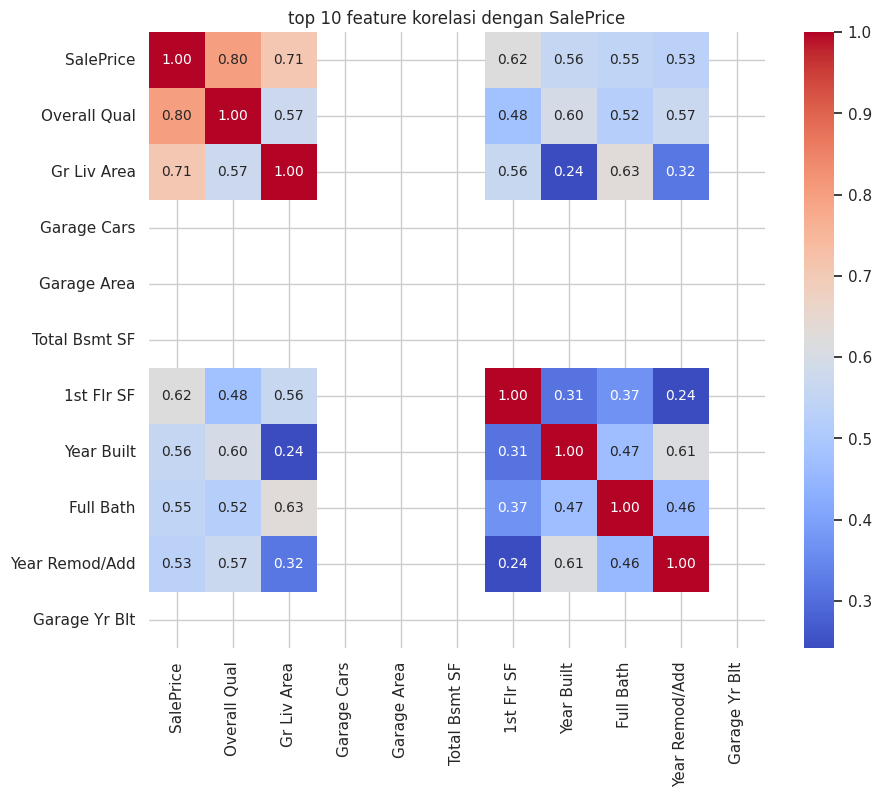

In [28]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

cols = corr.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)

sns.heatmap(cm, cbar=True,
            annot=True, square=True,
            fmt='.2f', annot_kws={'size': 10},
            yticklabels=cols.values, xticklabels=cols.values,
            cmap='coolwarm')
plt.title('top 10 feature korelasi dengan SalePrice')
plt.show()

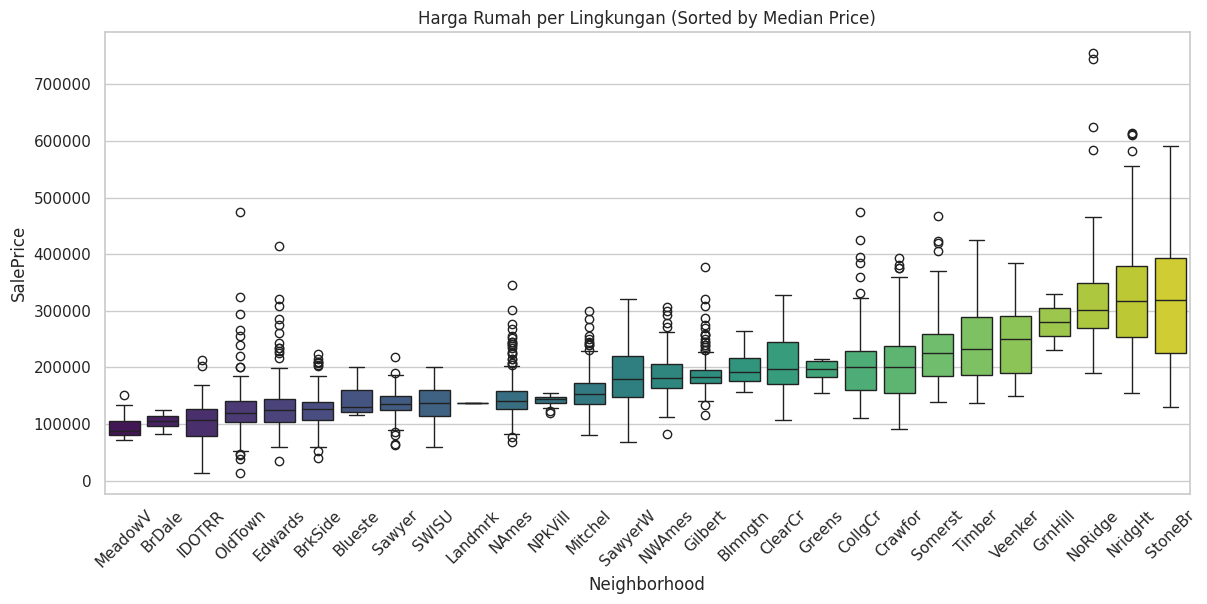

In [29]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))
sorted_nb = df.groupby('Neighborhood')['SalePrice'].median().sort_values().index
sns.boxplot(x='Neighborhood', y='SalePrice', data=df, order=sorted_nb, palette='viridis')
plt.xticks(rotation=45)
plt.title('Harga Rumah per Lingkungan (Sorted by Median Price)')
plt.show()

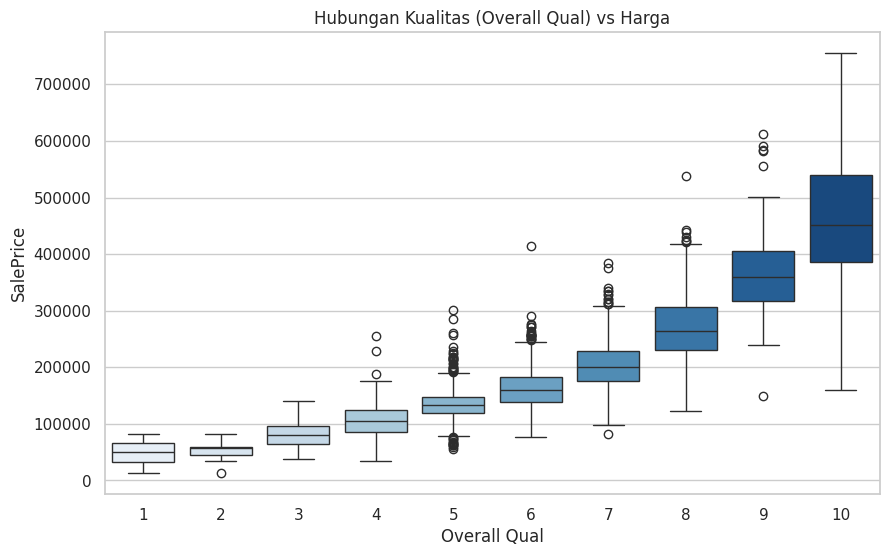

In [30]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Overall Qual', y='SalePrice', data=df, palette='Blues')
plt.title('Hubungan Kualitas (Overall Qual) vs Harga')
plt.show()

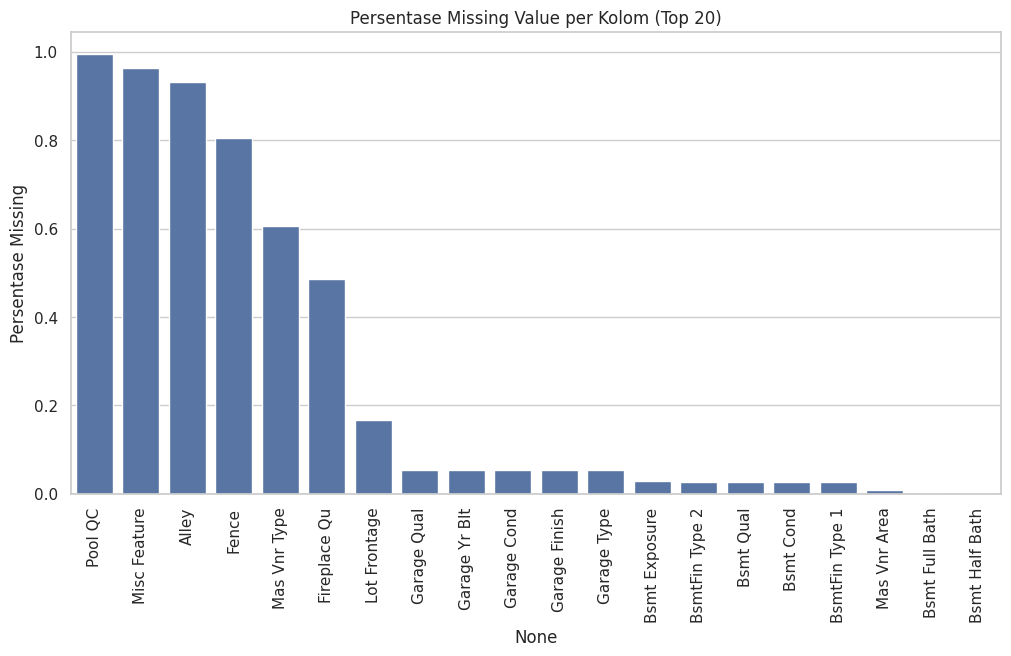

In [32]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]

if not missing_data.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_data.index[:20], y=missing_data['Percent'][:20])
    plt.xticks(rotation=90)
    plt.title('Persentase Missing Value per Kolom (Top 20)')
    plt.ylabel('Persentase Missing')
    plt.show()
else:
    print("Tidak ada missing value di dataset!")

## feature engineering

log1p untuk sale price

In [33]:
df['saleprice_log'] = np.log1p(df['SalePrice'])
print(f"skewness saleprice {df['saleprice_log'].skew():.4f}")

skewness saleprice -0.0148


missing value

In [38]:
missing = df.isna().sum()
print(missing[missing > 0])

Lot Frontage       490
Alley             2732
Mas Vnr Type      1775
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64


In [42]:
cols_none = [
    'Alley', 'Mas Vnr Type', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type',
    'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature'
]

for col in cols_none:
    df[col] = df[col].fillna("None")

In [43]:
cols_zero = [
    'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
    'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars', 'Garage Area', 'Garage Yr Blt'
]

for col in cols_zero:
    df[col] = df[col].fillna(0)

In [48]:
df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(x.median()))

In [45]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [52]:
missing = df.isna().sum()
print(missing[missing > 0])

Lot Frontage    3
dtype: int64


fill nan Lot Frontage dengan median global

In [53]:
df['Lot Frontage'] = df['Lot Frontage'].fillna(df['Lot Frontage'].median())

In [54]:
missing = df.isna().sum()
print(missing[missing > 0])

Series([], dtype: int64)


missing done

cek data

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2930 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            2930 non-null   object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

drop unnecessary col

In [56]:
df.drop(['PID', 'Order'], axis=1, inplace=True)

age feature for year

In [58]:
df['House Age'] = df['Yr Sold'] - df['Year Built']
df['Remod Age'] = df['Yr Sold'] - df['Year Remod/Add']
df['Garage Age'] = df['Yr Sold'] - df['Garage Yr Blt']

df.loc[df['Garage Yr Blt'] == 0, 'Garage Age'] = 0

df['House Age'] = df['House Age'].clip(lower=0)
df['Remod Age'] = df['Remod Age'].clip(lower=0)
df['Garage Age'] = df['Garage Age'].clip(lower=0)

cols_to_drop = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
df = df.drop(columns=cols_to_drop)

## split data

In [61]:
X = df.drop(columns=['SalePrice', 'saleprice_log'])
y = df['saleprice_log']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

In [63]:
num_features = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
    'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
    'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
    'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
    'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
    'House Age', 'Remod Age', 'Garage Age'
]

ordinal_features = [
    'Overall Qual', 'Overall Cond', 'Lot Shape', 'Utilities', 'Land Slope',
    'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual',
    'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond',
    'Paved Drive', 'Pool QC', 'Fence'
]

nominal_features = [
    col for col in X_train.columns
    if col not in num_features + ordinal_features
]

preprocessing

In [76]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

nom_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('ord', ord_pipe, ordinal_features),
    ('nom', nom_pipe, nominal_features)
])

modelling

In [77]:
model_lin = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression(
        fit_intercept=True,
        n_jobs=-1
    ))
])

model_ridge = Pipeline([
    ('prep', preprocessor),
    ('model', Ridge(
        alpha=1.0,
        solver='auto',
        random_state=42
    ))
])

model_lasso = Pipeline([
    ('prep', preprocessor),
    ('model', Lasso(
        alpha=0.001,
        max_iter=10_000,
        random_state=42
    ))
])

eval n

In [78]:
model_lin.fit(X_train, y_train)

y_pred_lin = model_lin.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print("linear")
print(f"MAE  : {mae_lin:.3f}")
print(f"RMSE : {rmse_lin:.3f}")
print(f"R²   : {r2_lin:.3f}")

linear
MAE  : 0.076
RMSE : 0.123
R²   : 0.918


In [79]:
model_ridge.fit(X_train, y_train)

y_pred_ridge = model_ridge.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("ridge")
print(f"MAE  : {mae_ridge:.3f}")
print(f"RMSE : {rmse_ridge:.3f}")
print(f"R²   : {r2_ridge:.3f}")

ridge
MAE  : 0.078
RMSE : 0.119
R²   : 0.923


In [80]:
model_lasso.fit(X_train, y_train)

y_pred_lasso = model_lasso.predict(X_test)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("lasso")
print(f"MAE  : {mae_lasso:.3f}")
print(f"RMSE : {rmse_lasso:.3f}")
print(f"R²   : {r2_lasso:.3f}")

lasso
MAE  : 0.081
RMSE : 0.121
R²   : 0.921


hyperparameter tuning

In [84]:
param_ridge = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 200.0],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

param_lasso = {
    'model__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1.0],
    'model__max_iter': [10000, 50000]
}

models = [
    ('Ridge', model_ridge, param_ridge),
    ('Lasso', model_lasso, param_lasso)
]

best_models = {}

print("tuning hyperparameter\n")

for name, pipeline, params in models:
    print(f"tuning {name}...")

    grid = GridSearchCV(
        pipeline,
        params,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_

    print(f"  Best Params: {grid.best_params_}\n")
    print(f"  Best CV RMSE: {-grid.best_score_:.4f}\n")

results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2 Score': r2
    })

df_results = pd.DataFrame(results)
print(df_results)

tuning hyperparameter

tuning Ridge...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
  Best Params: {'model__alpha': 10.0, 'model__solver': 'auto'}

  Best CV RMSE: 0.1399

tuning Lasso...
Fitting 5 folds for each of 14 candidates, totalling 70 fits
  Best Params: {'model__alpha': 0.0005, 'model__max_iter': 10000}

  Best CV RMSE: 0.1401

   Model       MAE      RMSE  R2 Score
0  Ridge  0.078842  0.118160  0.924543
1  Lasso  0.078138  0.118505  0.924101


coeff ridge

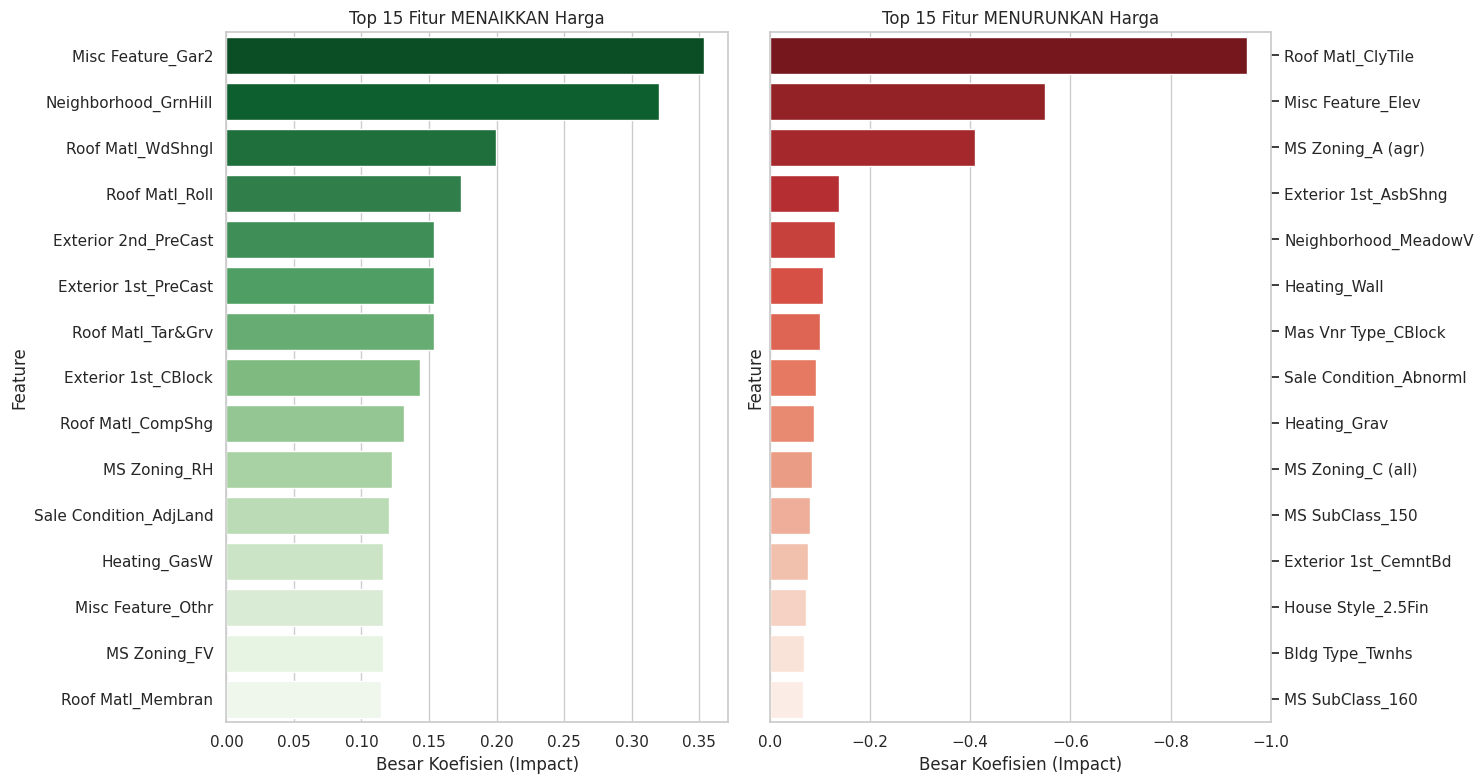

In [89]:
final_model = model_ridge

feature_names = final_model.named_steps['prep'].get_feature_names_out()
coefficients = final_model.named_steps['model'].coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Feature'] = coef_df['Feature'].str.replace(r'^(num__|nom__|ord__)', '', regex=True)
coef_df['abs_coef'] = coef_df['Coefficient'].abs()

top_pos = coef_df.sort_values('Coefficient', ascending=False).head(15)
top_neg = coef_df.sort_values('Coefficient', ascending=True).head(15)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.barplot(data=top_pos, x='Coefficient', y='Feature', ax=ax[0], palette='Greens_r')
ax[0].set_title('Top 15 Fitur MENAIKKAN Harga')
ax[0].set_xlabel('Besar Koefisien (Impact)')

sns.barplot(data=top_neg, x='Coefficient', y='Feature', ax=ax[1], palette='Reds_r')
ax[1].set_title('Top 15 Fitur MENURUNKAN Harga')
ax[1].set_xlabel('Besar Koefisien (Impact)')
ax[1].invert_xaxis()
ax[1].yaxis.tick_right()

plt.tight_layout()
plt.show()

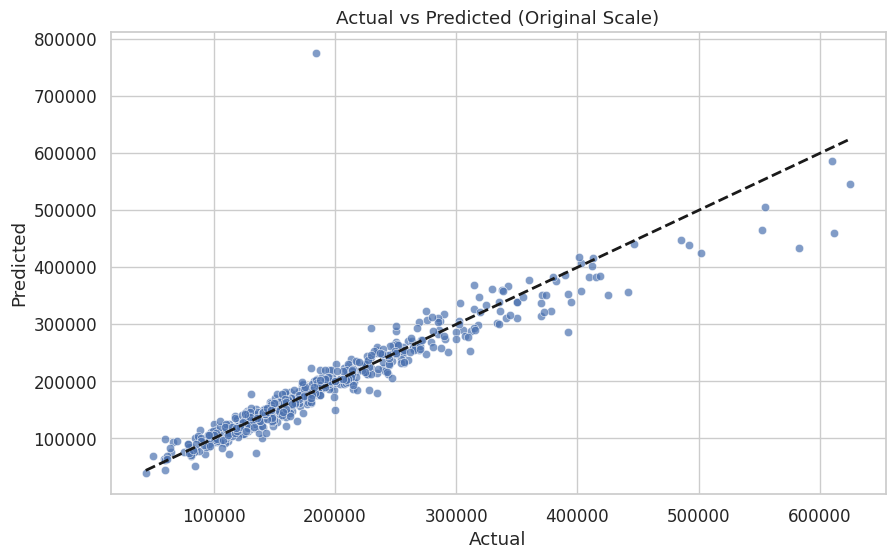

In [91]:
sns.set(style="whitegrid", font_scale=1.1)

y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred_ridge)

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test_exp, y=y_pred_exp, alpha=0.7)
plt.plot([y_test_exp.min(), y_test_exp.max()],
         [y_test_exp.min(), y_test_exp.max()],
         'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Original Scale)")
plt.show()